In [1]:
import math
import numpy as np
import pandas as pd
import scipy as sc
import matplotlib.pyplot as plt
from scipy.integrate import quad, trapz

import scipy.stats
import scipy.optimize
from scipy.signal import find_peaks

%pylab inline

from lmfit import minimize, Parameters, Model

print(sc.__version__)

Populating the interactive namespace from numpy and matplotlib
1.1.0


In [2]:
def gauss(x, mu, sigma, k):
    return k*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sigma, 2.)))

def line(x, a, b):
    return a*x+b

def breit_vigner2(x, M, w = 11.3, alpha = 0.018):
    G = alpha * (w ** 2) + 1
    #G = alpha * (w ** 2)
    y = M * (G**1) * (1-np.exp(-(x/G)**2) ) / ((x - w)**2 + (G**2)/1)
    return np.round(y, decimals=5) #округляем чтобы убрать неустойчивость расчета изза хвостов

def breit_vigner3(x, M, w,  G1):
    G = G1
    y = M * (G**1) * (1-np.exp(-(x/G)**2) ) / ((x - w)**2 + (G**2)/1)
    return np.round(y, decimals=5) #округляем чтобы убрать неустойчивость расчета изза хвостов

In [3]:
def QFC_back(E, E_qf, N_0, W = 22, T = 100):
    Q_EC_76As=0.9233
    S_p_76As=7.723
    E_t_gs = 420 - Q_EC_76As
    E_0 = E_t_gs - S_p_76As
    x = E_t_gs - E
    return N_0 * ( 1 - np.exp((x-E_0)/T) )/( 1 + ((x-E_qf)/W)**2)

def QFC_back2(x, E_qf, N_0, W, T):
    Q_EC_76As=0.9233
    S_p_76As=7.723
    E_t_gs = 420 - Q_EC_76As
    E_0 = E_t_gs - S_p_76As
    E = E_t_gs - x
    return N_0 * ( 1 - np.exp((E-E_0)/T) )/( 1 + ((E-E_qf)/W)**2)

def QFC_back3(x, E_qf, N_0, W, T):
    Q_EC_76As=0.9233
    S_p_76As=7.723
    E_t_gs = 420 - Q_EC_76As
    E_0 = E_t_gs - S_p_76As
    E = E_t_gs - x
    
    values = N_0 * ( 1 - np.exp((E-E_0)/T) )/( 1 + ((E-E_qf)/W)**2)
    values_more0 = values[ np.where(values>0) ]
    beginning = np.zeros((len(x)-len(values_more0)))
    return np.concatenate((beginning, values_more0))


(0, 6)

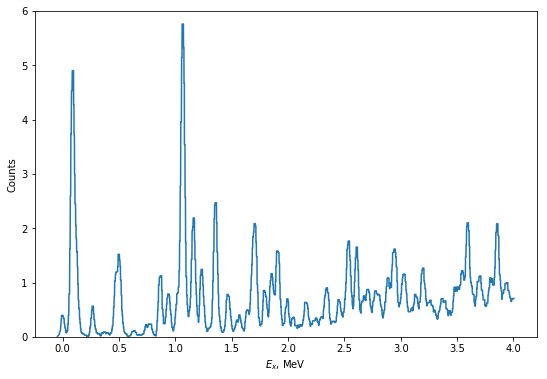

In [4]:
red_0_4 = pd.read_csv('0_4_new.csv', 
                      sep='\t', decimal=',')

plt.figure(figsize=(9,6))
plt.plot(red_0_4['x'].values, red_0_4['y'].values)
plt.xlabel('$E_x$, MeV')
plt.ylabel('Counts')
plt.ylim(0,6)

(0, 6)

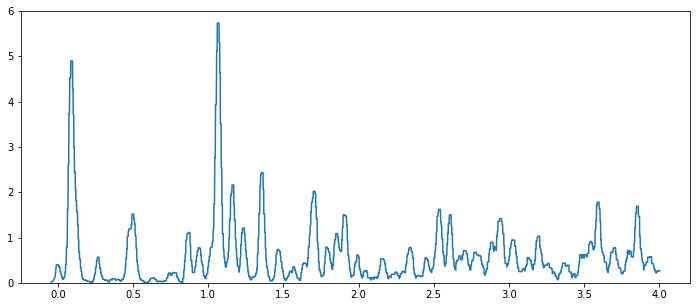

In [5]:
E_qf = 395.91689
N_0 = 7.51562882
G1 = 3.0
M = 8.0
a=np.linspace(0,45,1000)

x_data = red_0_4['x'].values
y_data = red_0_4['y'].values

y_bv3 = breit_vigner3(x_data, M, 11.3, G1)
y_QFC = QFC_back3(x_data, E_qf, N_0, 24, 100)
y_gauss_SDR = gauss(x_data, 18.5, 2.7,0.3)
pygmy1_n = gauss(x_data, 8.3, 0.9, 0.5)
pygmy2_n = gauss(x_data, 5.9, 1, 0.75)

plt.figure(figsize=(12,5))
#plt.plot(x_data, y_data)
#plt.plot(x_data, y_bv3+y_QFC+y_gauss_SDR+pygmy1_n+pygmy2_n)
plt.plot(x_data, y_data-(y_bv3+y_QFC+y_gauss_SDR+pygmy1_n+pygmy2_n))
#plt.plot(a, QFC_back2(a, E_qf, N_0, 24, 100))
#plt.plot(x_data, y_bv3, ls='--')
#plt.plot(x_data, y_QFC, ls='--')
#plt.plot(x_data, y_gauss_SDR, ls='--')
#plt.plot(x_data, pygmy1_n, ls='--')
#plt.plot(x_data, pygmy2_n, ls='--')
plt.ylim(0,6)

### B(GT)

In [6]:
BGT=pd.read_csv('../B(GT) peaks processing//clear_B(GT).csv') #таблица со значениями B(GT)
BGT.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73 entries, 0 to 72
Data columns (total 5 columns):
Unnamed: 0        73 non-null int64
Ex                73 non-null float64
Jpi               73 non-null object
diff cross-sec    73 non-null float64
B(GT)             73 non-null float64
dtypes: float64(3), int64(1), object(1)
memory usage: 2.9+ KB


In [7]:
BGT['B(GT)'] = BGT['B(GT)']/10 #делим на 10 т.к. в таблице все значения домножены на 10
BGT['Ex'] = BGT['Ex']/1000
BGT = BGT[ BGT['Jpi'] == '1' ] #отбираем уравни с Jpi == 1
np.sum(BGT['B(GT)'].values)

1.544

In [8]:
BGT[ BGT['Ex']<1 ]['Ex'].values

array([0.086 , 0.12  , 0.265 , 0.5138, 0.864 , 0.936 ])

In [16]:
BGT[ BGT['Ex']<1 ]['B(GT)'].values

array([0.12 , 0.033, 0.01 , 0.071, 0.025, 0.018])

(0, 6)

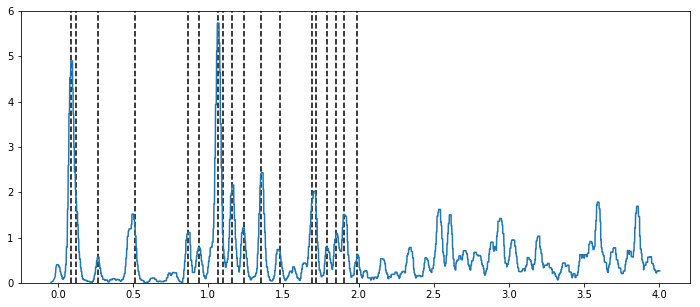

In [52]:
y_data2 = y_data-(y_bv3+y_QFC+y_gauss_SDR+pygmy1_n+pygmy2_n)

plt.figure(figsize=(12,5))
plt.plot(x_data, y_data2)
for elem in BGT[ BGT['Ex']<2 ]['Ex'].values:
    plt.vlines(elem, 0,6,  linestyle='dashed')
plt.ylim(0,6)

In [43]:
integrals = []
BGT_values = []
Ex_values = []
BGT[BGT['Ex']==0.086]['B(GT)'].values

array([0.12])

0.2498002425723763


(0.04, 0.2)

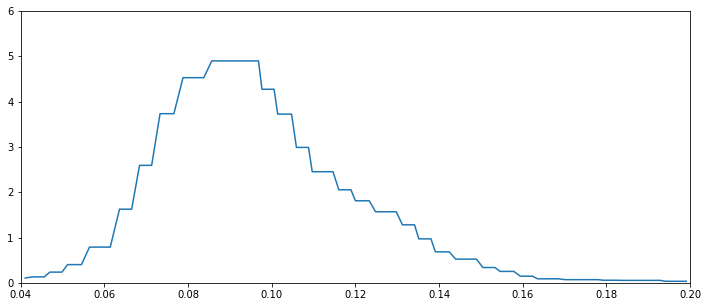

In [44]:
peak0086_012 = (x_data[np.where((x_data>0.04) & (x_data<0.2))], y_data[np.where((x_data>0.04) & (x_data<0.2))])

integrals.append(trapz(peak0086_012[1], peak0086_012[0]))
BGT_values.append( BGT[BGT['Ex']==0.086]['B(GT)'].values[0]+BGT[BGT['Ex']==0.12]['B(GT)'].values[0] )
Ex_values.append(0.086)
print(trapz(peak0086_012[1], peak0086_012[0]) )

plt.figure(figsize=(12,5))
plt.plot(peak0086_012[0], peak0086_012[1])
plt.ylim(0,6)
plt.xlim(0.04,0.2)

0.02198791044267358


(0, 6)

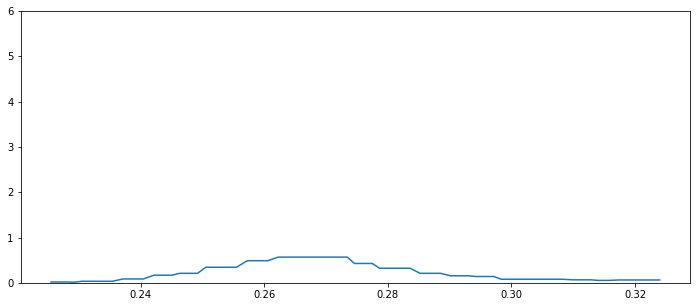

In [30]:
index = np.where((x_data>0.225) & (x_data<0.325))
peak0265 = (x_data[index], y_data[index])

print(trapz(peak0265[1], peak0265[0]) )

plt.figure(figsize=(12,5))
plt.plot(peak0265[0], peak0265[1])
plt.ylim(0,6)

In [45]:
integrals.append(trapz(peak0265[1], peak0265[0]))
BGT_values.append( BGT[BGT['Ex']==0.265]['B(GT)'].values[0] )
Ex_values.append(0.265)

0.04763131945541458


(0, 6)

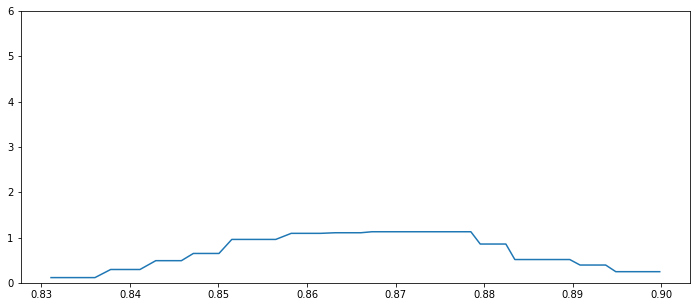

In [46]:
index = np.where((x_data>0.83) & (x_data<0.9))
peak0864 = (x_data[index], y_data[index])

print(trapz(peak0864[1], peak0864[0]) )

plt.figure(figsize=(12,5))
plt.plot(peak0864[0], peak0864[1])
plt.ylim(0,6)

In [47]:
integrals.append(trapz(peak0864[1], peak0864[0]))
BGT_values.append( BGT[BGT['Ex']==0.864]['B(GT)'].values[0] )
Ex_values.append(0.864)

0.03813317817335402


(0, 6)

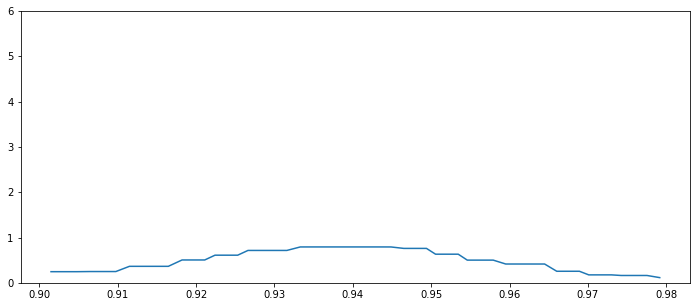

In [48]:
index = np.where((x_data>0.9) & (x_data<0.98))
peak0936 = (x_data[index], y_data[index])

print(trapz(peak0936[1], peak0936[0]) )

plt.figure(figsize=(12,5))
plt.plot(peak0936[0], peak0936[1])
plt.ylim(0,6)

In [49]:
integrals.append(trapz(peak0936[1], peak0936[0]))
BGT_values.append( BGT[BGT['Ex']==0.936]['B(GT)'].values[0] )
Ex_values.append(0.936)

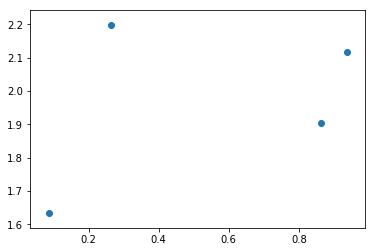

In [51]:
plt.scatter(np.array(Ex_values), np.array(integrals)/np.array(BGT_values))